# Summary
Notebook for study of strategies and techniques for analysis of time series data.

Based on: https://learn.datacamp.com/courses/time-series-analysis-in-python

# Preprocessing

In [101]:
import io
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

url = "https://www.ic.unicamp.br/~wainer/cursos/1s2021/432/ouro2.csv"
s = requests.get(url).content
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y') # Parser for brasilian date format
df = pd.read_csv(io.StringIO(s.decode('utf-8')), parse_dates=['Data'], index_col='Data', date_parser=dateparse) # Convert the index into datetime

X = df.sort_index().iloc[:-100] # The last 100 observations are the test set
y = df.sort_index().iloc[-100:]

print(X.tail())
print(y.head())

             Valor
Data              
2019-06-16  1432.7
2019-06-23  1446.8
2019-06-30  1436.6
2019-07-07  1450.9
2019-07-14  1465.5
             Valor
Data              
2019-07-21  1460.4
2019-07-28  1485.3
2019-08-04  1534.5
2019-08-11  1549.2
2019-08-18  1563.5


# Annual Analysis

    2000   2001   2002   2003   2004  ...    2014    2015    2016    2017    2018
0  282.7  263.9  287.4  354.5  426.4  ...  1246.7  1357.4  1151.7  1255.7  1425.7
1  290.1  264.3  283.1  356.6  406.7  ...  1251.7  1404.9  1137.5  1281.3  1425.9
2  283.2  262.8  278.8  368.2  407.9  ...  1264.5  1417.6  1142.6  1289.2  1453.7
3  281.1  267.1  286.0  368.3  402.2  ...  1240.1  1384.6  1161.9  1271.7  1434.6
4  280.1  259.9  303.5  369.9  403.6  ...  1263.3  1332.6  1198.0  1302.2  1410.1

[5 rows x 361 columns]


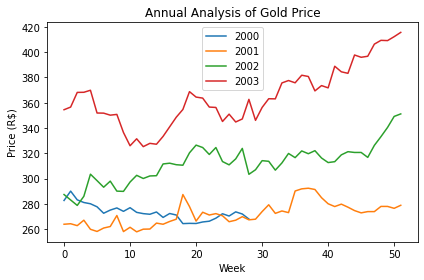

In [80]:
price_per_year = pd.DataFrame()

for year in list(range(2000, 2019, 1)):
  year = str(year)  
  price_year = X.loc[year, ['Valor']].reset_index(drop=True)
  price_year.rename(columns={'Valor':year}, inplace=True)
  price_per_year = pd.concat([valores, price_per_year], axis=1)

# Print
print(price_per_year.head())

# Plot
price_per_year.iloc[:,0:4].plot()
plt.title('Annual Analysis of Gold Price')
plt.ylabel('Price (R$)')
plt.xlabel('Week')
plt.tight_layout(); plt.show()

# Techniques

## Shifting

In [88]:
X_shifted = X.copy()
X_shifted['lagged'] = X.Valor.shift(periods=-1)
X_shifted['shifted'] = X.Valor.shift(periods=1)
X_shifted['diff'] = X.Valor.diff(periods=1)
X_shifted['pct_change'] = X.Valor.pct_change().mul(100)

print(X_shifted.head(10))

            Valor  lagged  shifted  diff  pct_change
Data                                                
2000-06-18  282.7   290.1      NaN   NaN         NaN
2000-06-25  290.1   283.2    282.7   7.4    2.617616
2000-07-02  283.2   281.1    290.1  -6.9   -2.378490
2000-07-09  281.1   280.1    283.2  -2.1   -0.741525
2000-07-16  280.1   277.7    281.1  -1.0   -0.355745
2000-07-23  277.7   272.6    280.1  -2.4   -0.856837
2000-07-30  272.6   275.1    277.7  -5.1   -1.836514
2000-08-06  275.1   276.8    272.6   2.5    0.917095
2000-08-13  276.8   274.1    275.1   1.7    0.617957
2000-08-20  274.1   277.0    276.8  -2.7   -0.975434


## Normalizing

               Valor
Data                
2000-06-18  0.000000
2000-06-25  2.617616
2000-07-02  0.176866
2000-07-09 -0.565971
2000-07-16 -0.919703


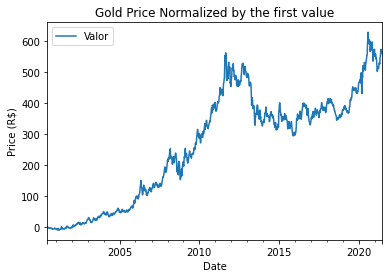

In [105]:
first_row = df.sort_index().iloc[0]
X_normalized = df.sort_index().div(first_row).sub(1).mul(100)
print(X_normalized.head())
X_normalized.plot(subplots=False)

plt.title('Gold Price Normalized by the first value')
plt.ylabel('Price (R$)')
plt.xlabel('Date')

plt.show()

## Resample

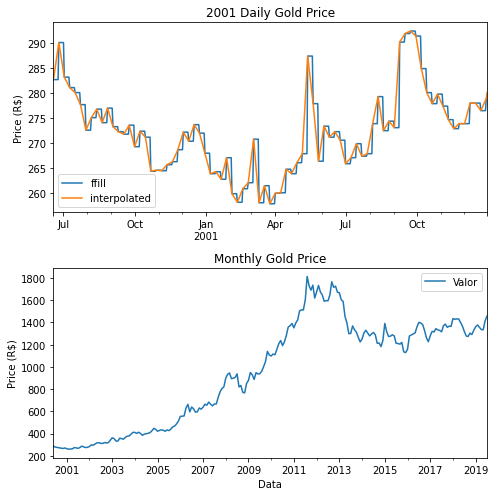

In [120]:
dates = pd.date_range(start='2000-06-18', end='2021-06-13', freq='w')
weekly = pd.Series(data=X.Valor, index=dates)

fig, ax = plt.subplots(2, 1, figsize=(7,7))

daily = pd.DataFrame()
daily['ffill'] = weekly.asfreq('D', method='ffill')
daily['interpolated'] = weekly.asfreq('D').interpolate()
daily.loc['2000-06-18':'2001'].plot(ax=ax[0], title='2001 Daily Gold Price')
ax[0].set_ylabel('Price (R$)')

monthly = X.resample('M').mean()
monthly.plot(ax=ax[1], title='Monthly Gold Price')
ax[1].set_ylabel('Price (R$)')
plt.tight_layout(); plt.show()

monthly_dates = pd.date_range(start=weekly.index.min(), end=weekly.index.max(), freq='M')

## Rolling

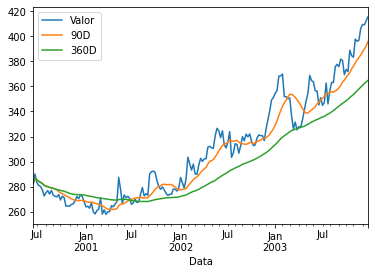

In [90]:
rolling = X.copy()
rolling['90D'] = X.Valor.rolling(window='90D').mean()
rolling['360D'] = X.Valor.rolling(window='360D').mean()
rolling.loc['2000':'2003'].plot()
plt.show()

# Autcorrelatation
Autocorrelation means the correlation of a series with lagged-one itself. If it has a positive autocorrelation means that it has a momentum, i.e., the value doesn't change so fast. And it implies that the series can be forecast from the past. Sometimes we need to resample the data because the autocorrelation can exist with a different frequence of the data

In [104]:
X_weekly = X.copy().Valor
X_monthly = X.resample('M').mean().Valor
X_annual = X.resample('A').mean().Valor

freq_df = pd.DataFrame({'Frequence':['Weekly','Monthly','Yearly'],
                  'Autocorrelation':[X_weekly.autocorr(), X_monthly.autocorr(), X_annual.autocorr()]
                   })

freq_df

,Frequence,Autocorrelation
0,Weekly,0.998572
1,Monthly,0.996013
2,Yearly,0.962954


We can see the autocorrelation of the data with many lagged versions of itself. To do this, we use the ACF

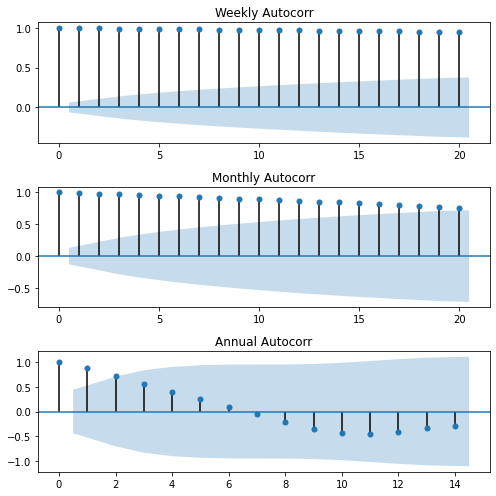

In [74]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(3,1, figsize=(7,7))
plot_acf(X_weekly, lags=20, ax=axes[0], title='Weekly Autocorr')
plot_acf(X_monthly, lags=20, ax=axes[1], title='Monthly Autocorr')
plot_acf(X_annual, ax=axes[2], title='Annual Autocorr')
plt.tight_layout()
plt.show()

# Random Walk
Being a Random Walk means that the Gold Price varies according to a white noise, which means it's unpredicatable. So the best forecast for tomorrow's price is today's price. 

The chance of a series being a Random Walk is given by the p-value of the ADF test

Valor p do teste ADF:  0.7030351496580385


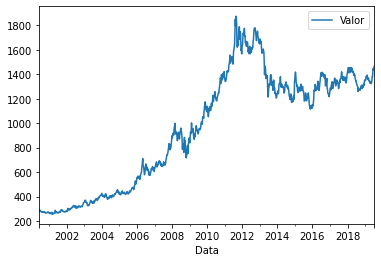

In [71]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(X.Valor)
print("Valor p do teste ADF: ", result[1])

X.plot()
plt.show()

By the result, and looking at the plot, we can assume that the gold price is a Random Walk with drift,  because it tends to drift up over time

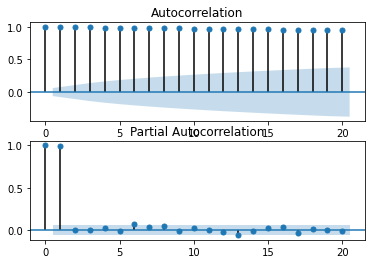

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

chg = X.diff().dropna()

fig, axes = plt.subplots(2,1)
plot_acf(X, lags=20, ax=axes[0])
plot_pacf(X, lags=20, ax=axes[1])
plt.show()